In [18]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [19]:
import tensorflow as tf
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6485335845940938017
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14626652160
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13000265508510150648
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [20]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt

In [21]:
# veri seti / dataset -> https://www.kaggle.com/datasets/puneet6060/intel-image-classification
path="/gdrive/My Drive/Colab Notebooks/my gan study/mountain/"
image_labels = os.listdir(path)
batch_size=32

images=[]
for i in image_labels:
    img=load_img(path+i, color_mode='rgb', target_size=(150, 150), interpolation='nearest')
    images.append(img_to_array(img))
images=np.array(images)

In [22]:
images[1].shape

(150, 150, 3)

In [23]:
from skimage.transform import resize
images = resize(images, (images.shape[0], 64, 64, 3), preserve_range=True).astype("float32")

images=images/255
images.shape

(2512, 64, 64, 3)

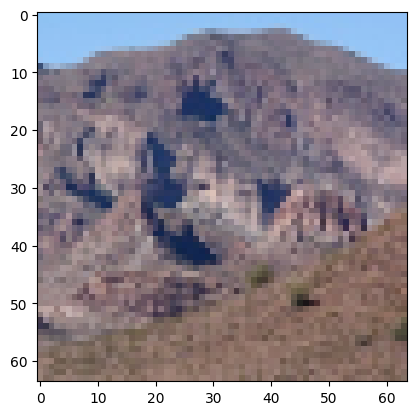

293.jpg
(64, 64, 3)


In [24]:
plt.imshow(images[0])
plt.show()
print(image_labels[0])
print(images[0].shape)

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

def display(images, row=2, col=10):
    fig = plt.figure(figsize=(20, 3))
    it = 0
    for r in range(row):
        for c in range(col):
            ax = plt.subplot(row, col, it + 1)
            ax.set_axis_off()
            ax.imshow(images[it, :, :, :])
            it += 1
    return fig

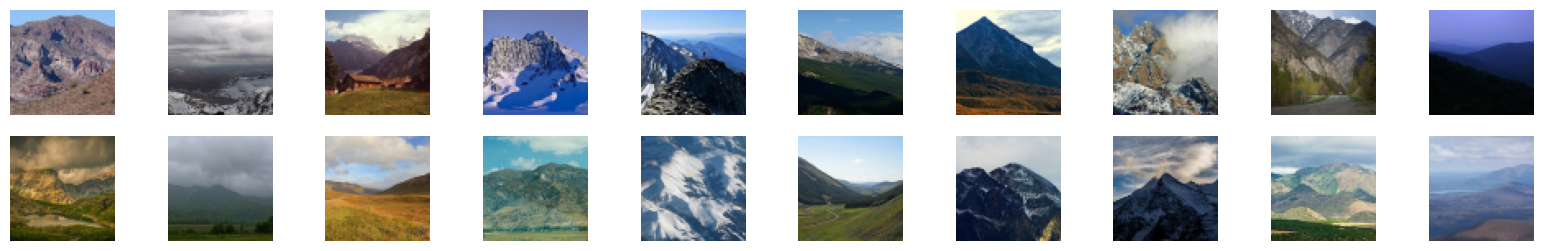

In [26]:
display(images);

In [27]:
data_generator = tf.data.Dataset.from_tensor_slices(images).shuffle(100).batch(batch_size, drop_remainder=True)

In [28]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, Input, Flatten
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model

def get_generator():

    input_noise = Input(shape=(1, 1, 100))

    x=Conv2DTranspose(1024, kernel_size=4, strides=2, padding='valid')(input_noise)
    x=BatchNormalization()(x)
    x=LeakyReLU(0.2)(x)

    x=Conv2DTranspose(512, kernel_size=4, strides=2, padding='same')(x)
    x=BatchNormalization()(x)
    x=LeakyReLU(0.2)(x)

    x=Conv2DTranspose(256, kernel_size=4, strides=2, padding='same')(x)
    x=BatchNormalization()(x)
    x=LeakyReLU(0.2)(x)

    x=Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)
    x=BatchNormalization()(x)
    x=LeakyReLU(0.2)(x)

    x=Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh')(x)

    return Model(inputs=input_noise, outputs=x)


def get_discriminator():

    input_image = Input(shape=(64, 64, 3))

    x = Conv2D(128, kernel_size=4, strides=2, padding="same")(input_image)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, kernel_size=4, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(1024, kernel_size=4, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(3, kernel_size=4, strides=1, padding="valid")(x)
    x = Flatten()(x)

    return Model(inputs=input_image, outputs=x)

generator = get_generator()
discriminator = get_discriminator()

In [29]:
def get_noise(batch_size, nz=100):
    return tf.random.normal([batch_size, 1, 1, nz])

noise = get_noise(batch_size)

print("init", noise.shape)
fake_images = generator(noise)
print("Fake images", fake_images.shape)
preds = discriminator(fake_images)
print("Predictions", preds.shape)

init (32, 1, 1, 100)
Fake images (32, 64, 64, 3)
Predictions (32, 3)


In [30]:
generator.summary()
discriminator.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 1, 1, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 4, 4, 1024)          │       1,639,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 4, 4, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 4, 4, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 8, 8, 512)           │       8,389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 8, 8, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 16, 16, 256)         │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 32, 32, 128)         │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_9 (Conv2DTranspose) │ (None, 64, 64, 3)           │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,664,195 (48.31 MB)

 Trainable params: 12,660,355 (48.30 MB)

 Non-trainable params: 3,840 (15.00 KB)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_12 (LeakyReLU)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_13 (LeakyReLU)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 512)           │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 8, 8, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_14 (LeakyReLU)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 4, 4, 1024)          │       8,389,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 4, 4, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_15 (LeakyReLU)           │ (None, 4, 4, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 1, 1, 3)             │          49,155 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,074,947 (42.25 MB)

 Trainable params: 11,071,107 (42.23 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [31]:
from tensorflow.keras.losses import binary_crossentropy

def discriminator_loss(preds_real, preds_fake):
    loss_real = binary_crossentropy(tf.ones_like(preds_real), preds_real, from_logits=True)
    loss_fake = binary_crossentropy(tf.zeros_like(preds_fake), preds_fake, from_logits=True)
    return loss_real + loss_fake

def generator_loss(preds_fake):
    return binary_crossentropy(tf.ones_like(preds_fake), preds_fake, from_logits=True)

In [32]:
from tensorflow.keras.optimizers import Adam

optimizer_d = Adam(learning_rate=1e-4, beta_1=0.5)
optimizer_g = Adam(learning_rate=1e-4, beta_1=0.5)

In [33]:
@tf.function
def train_step(images):
    noise = get_noise(images.shape[0])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(preds_fake=fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    optimizer_g.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    optimizer_d.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return disc_loss, gen_loss

In [34]:
from tensorflow.keras.metrics import Mean

epochs = 200

fixed_noise = get_noise(5)

print("Base noise:")
fake_images = generator(fixed_noise, training=False).numpy()
plt.imshow(fake_images[0])
plt.show()

for epoch in range(epochs):
    print("====== Epoch {:2d} ======".format(epoch))

    epoch_loss_d = Mean()
    epoch_loss_g = Mean()

    epoch_len = tf.data.experimental.cardinality(data_generator)
    for i, real_images in enumerate(data_generator):
        loss_d, loss_g = train_step(real_images)
        epoch_loss_d(loss_d)
        epoch_loss_g(loss_g)

        if i % 10 == 0 and i > 0:
            print(i, end=" ... ")

    print("\nDiscriminator: {}, Generator: {}".format(
        epoch_loss_d.result(), epoch_loss_g.result()))
    fake_images = generator(fixed_noise, training=False).numpy()
    plt.imshow(fake_images[0])
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

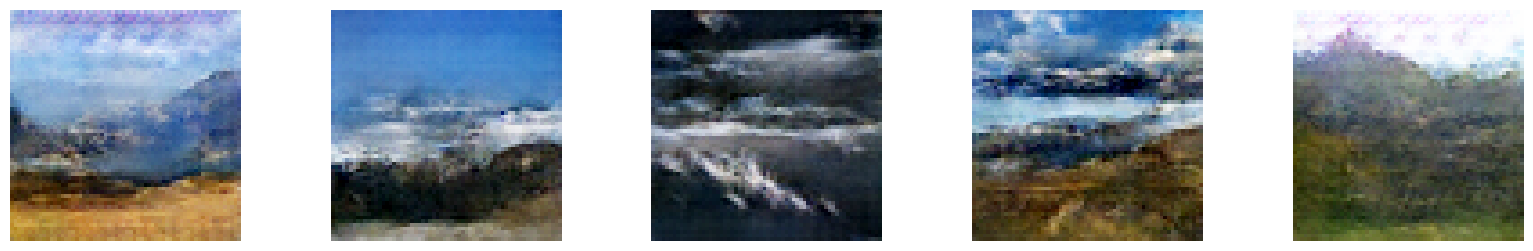

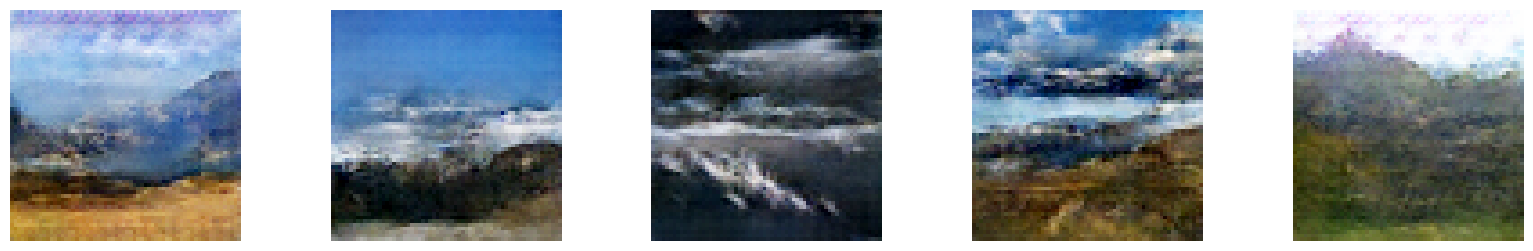

In [35]:
display(fake_images, row=1, col=5)